I'm looking into doing a delta_sigma emulator. This is testing if the cat side works. Then i'll make an emulator for it. 

In [1]:
from pearce.mocks import cat_dict
import numpy as np
from os import path
from astropy.io import fits

In [2]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
z_bins = np.array([0.15, 0.3, 0.45, 0.6, 0.75, 0.9])
zbin=1

In [4]:
zbc = (z_bins[1:]+z_bins[:-1])/2
print 1/(1+zbc)

[ 0.81632653  0.72727273  0.6557377   0.59701493  0.54794521]


In [5]:
a = 0.81120
z = 1.0/a - 1.0

Load up a snapshot at a redshift near the center of this bin. 

In [6]:
print z

0.232741617357


In [7]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[a]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(a, particles=True, tol = 0.01, downsample_factor=1e-3)

In [8]:
cat.load_model(a, 'redMagic')

In [9]:
params = cat.model.param_dict.copy()
#params['mean_occupation_centrals_assembias_param1'] = 0.0
#params['mean_occupation_satellites_assembias_param1'] = 0.0
#my clustering redmagic best fit
params['logMmin'] = 12.386
params['sigma_logM'] = 0.4111
params['f_c'] = 0.292
params['alpha'] = 1.110
params['logM1'] = 13.777
params['logM0'] = 11.43433

print params

{'logM1': 13.777, 'logMmin': 12.386, 'f_c': 0.292, 'logM0': 11.43433, 'sigma_logM': 0.4111, 'alpha': 1.11}


In [10]:
print cat

chinchilla
-------------------------
Halo finder:	 rockstar
Version name:	Lb400-2048
Cosmology:
LambdaCDM(H0=70 km / (Mpc s), Om0=0.286, Ode0=0.714, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)
Redshifts:	[0.23274161735700183]
-------------------------
Location:	/nfs/slac/g/ki/ki21/cosmo/yymao/sham_test/resolution-test/c400-2048//rockstar/hlists/
Lbox:	400.0
Particle Mass:	591421440.000000
Columns to Keep:
{'halo_upid': (6, 'i8'), 'halo_vacc': (56, 'f4'), 'halo_vmax': (16, 'f4'), 'halo_rs_klypin': (34, 'f4'), 'halo_snapnum': (31, 'i8'), 'halo_macc': (54, 'f4'), 'halo_halfmass_scale': (58, 'f4'), 'halo_y': (18, 'f4'), 'halo_id': (1, 'i8'), 'halo_x': (17, 'f4'), 'halo_vx': (20, 'f4'), 'halo_vy': (21, 'f4'), 'halo_vz': (22, 'f4'), 'halo_rs': (12, 'f4'), 'halo_rvir': (11, 'f4'), 'halo_vpeak': (57, 'f4'), 'halo_z': (19, 'f4'), 'halo_mvir': (10, 'f4')}


In [11]:
cat.populate(params)

In [12]:
nd_cat =  cat.calc_analytic_nd(params)
print nd_cat

0.000288586509328


In [13]:
W =  0.00275848072207
print W

0.00275848072207


In [14]:
rp_bins = np.logspace(-1.1, 1.8, 11) #binning used in buzzard mocks
rpoints = (rp_bins[1:]+rp_bins[:-1])/2

theta_bins = np.logspace(np.log10(2.5), np.log10(250), 21)/60
tpoints = (theta_bins[1:]+theta_bins[:-1])/2

In [15]:
wt = cat.calc_wt(theta_bins, W, n_cores = 2)

1526.39284849 0.0114918951773
945.980741685

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


 0.0114928321338
583.53718459 0.0114943126004
355.094661655 0.0114966683704
215.685827312 0.0115003949323
130.361768785 0.0115063102019
80.5700747517 0.0115157000258
51.3146889727 0.0115306416932
34.9711188155 0.0115543893408
24.8475067022 0.0115922647955
17.8029539859 0.0116528139466
12.7546217216 0.0117504304378
8.78135915916 0.0119089292391
6.0048041589 0.0121705003476
4.02324727057 0.0126135042994
2.66442362167 0.0133981601003
1.7286698489 0.0149102653586
1.04999938717 0.0184064440657
0.587031952818 0.0336397099834
0.0 0.0320757840893


In [16]:
import warnings
from scipy.interpolate import interp1d
rbins = np.logspace(-1.1, 1.8, 17) #make my own bins
xi = cat.calc_xi(rbins,do_jackknife=False,n_cores=2)

if np.any(xi<=0):
    warnings.warn("Some values of xi are less than 0. Setting to a small nonzero value. This may have unexpected behavior, check your HOD")
    xi[xi<=0] = 1e-3
#TODO I should be able to just specify my own rbins
rpoints = (rbins[:-1]+rbins[1:])/2.0
xi_rmin, xi_rmax = rpoints[0], rpoints[-1]

# make an interpolator for integrating
xi_interp = interp1d(np.log10(rpoints), np.log10(xi))

In [17]:
print np.log10(xi)
print xi_interp(np.log10(rpoints) )

[ 3.88401063  3.55275893  3.22227584  2.87235777  2.54266052  2.16373843
  1.76624393  1.35687724  0.94059694  0.56452148  0.28087344  0.00749165
 -0.30006752 -0.62647944 -0.9738299  -1.4089827 ]
[ 3.88401063  3.55275893  3.22227584  2.87235777  2.54266052  2.16373843
  1.76624393  1.35687724  0.94059694  0.56452148  0.28087344  0.00749165
 -0.30006752 -0.62647944 -0.9738299  -1.4089827 ]


In [18]:
import pyccl as ccl
# get the theotertical matter xi, for large scale estimates
names, vals = cat._get_cosmo_param_names_vals()
param_dict = { n:v for n,v in zip(names, vals)}

if 'Omega_c' not in param_dict:
    param_dict['Omega_c'] = param_dict['Omega_m'] - param_dict['Omega_b']
    del param_dict['Omega_m']

cosmo = ccl.Cosmology(**param_dict)

big_rbins = np.logspace(-1.1, 2.3, 41)
big_rpoints = (big_rbins[1:] + big_rbins[:-1])/2.0
big_xi_rmin = big_rpoints[0]
big_xi_rmax = big_rpoints[-1]
xi_mm = ccl.correlation_3d(cosmo, cat.a, big_rpoints)

xi_mm[xi_mm<0] = 1e-6

xi_mm_interp = interp1d(np.log10(big_rpoints), np.log10(xi_mm))

#correction factor
bias2 = np.power(10, xi_interp(1.2)-xi_mm_interp(1.2))

[]

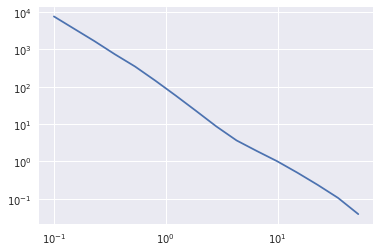

In [19]:
plt.plot(rpoints, xi)
plt.loglog()

[]

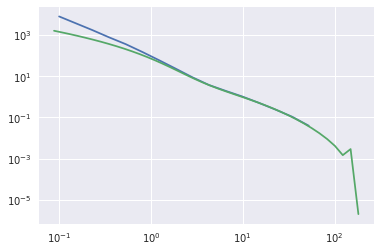

In [20]:
plt.plot(rpoints, xi)
plt.plot(big_rpoints, bias2*xi_mm)
plt.loglog()
#plt.xscale('log')

[]

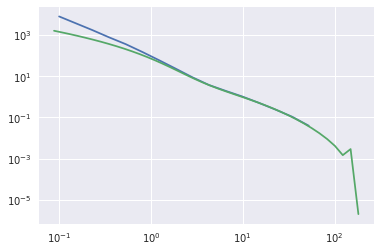

In [21]:
plt.plot(rpoints, 10**xi_interp(np.log10(rpoints)))
plt.plot(big_rpoints, bias2*(10**xi_mm_interp(np.log10(big_rpoints))))
plt.loglog()
#plt.xscale('log')

[]

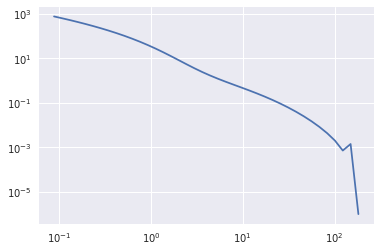

In [22]:
plt.plot(big_rpoints, xi_mm)
plt.loglog()
#plt.xscale('log')

In [23]:
_theta_bins = np.radians(theta_bins)
tpoints = (_theta_bins[1:] + _theta_bins[:-1])/2.0
_wt = np.zeros_like(tpoints)
# need this distance for computation
x = cat.cosmology.comoving_distance(cat.z).to("Mpc").value#/self.h

In [24]:
assert tpoints[0]*x/cat.h >= xi_rmin #TODO explain this check

In [55]:
def integrand(u, x, t, bias2, xi_interp, xi_mm_interp):
    r2 = u**2 + (x*t)**2
    if r2 < xi_rmin**2:
        return 0.0
    elif xi_rmin**2 < r2 < xi_rmax**2:
        return np.power(10, xi_interp(0.5*np.log10(r2)))
    elif r2 < big_xi_rmax**2:
        return bias2*np.power(10, xi_mm_interp(0.5*np.log10(r2)))
    else:
        return 0 

In [56]:
from scipy.integrate import quad
large_scales, small_scales = [], []
for bin_no, t_med in enumerate(tpoints):
    #log_u_ss_max = np.log(xi_rmax**2 - (t_med*x)**2)/2.0 #max we can integrate to on small scales
    log_u_ls_max = np.log(big_xi_rmax**2 - (t_med*x)**2)/2.0 #max we can integrate to on small scales
    '''
    if not np.isnan(log_u_ss_max):
        #print large_scales_integrand(log_u_ss_max, x, t_med, bias2, xi_mm_interp)

        small_scales_contribution = quad(small_scales_integrand, -10, log_u_ss_max, args = (x, t_med, xi_interp))[0]
        large_scales_contribution = quad(large_scales_integrand, log_u_ss_max, log_u_ls_max,\
                                     args = (x, t_med, bias2, xi_mm_interp))[0]
    else:
        small_scales_contribution = 0.0
        ls_start2 = big_xi_rmin**2 - (t_med*x)**2
        log_ls_start = np.log(ls_start2)/2.0 if ls_start2 > 0 else 
        large_scales_contribution = quad(large_scales_integrand, log_ls_start, log_u_ls_max,\
                                     args = (x, t_med, bias2, xi_mm_interp))[0]
    '''
    _wt[bin_no] = quad(integrand, -10, log_u_ls_max,\
                        args = (x, t_med, bias2, xi_interp, xi_mm_interp))[0]#(small_scales_contribution + large_scales_contribution)/cat.h #TODO check little h's 

_wt*=W/cat.h

In [57]:
_wt

array([ 1.28468331,  0.96113185,  0.71395692,  0.52587529,  0.38554872,
        0.28225087,  0.20928276,  0.15678195,  0.12103963,  0.09313361,
        0.07077738,  0.05250238,  0.03735565,  0.02601412,  0.01765816,
        0.01174975,  0.00765549,  0.00466415,  0.00269969,  0.00135223])

In [58]:
np.radians(theta_bins)

array([ 0.00072722,  0.00091552,  0.00115257,  0.001451  ,  0.0018267 ,
        0.00229967,  0.00289512,  0.00364474,  0.00458845,  0.00577652,
        0.00727221,  0.00915516,  0.01152567,  0.01450996,  0.01826695,
        0.02299673,  0.02895117,  0.03644736,  0.04588451,  0.05776518,
        0.07272205])

In [59]:
zbin = 1
wt_redmagic = np.loadtxt('/u/ki/swmclau2/Git/pearce/bin/mcmc/buzzard2_wt_%d%d.npy'%(zbin,zbin))
cov = np.loadtxt('/u/ki/swmclau2/Git/pearce/bin/mcmc/wt_11_cov.npy')

In [65]:
from astropy import units
def calc_wt(theta_bins, W, n_cores='all', halo = False, xi_kwargs = {}):
    """
    TODO docs
    """

    tpoints = np.radians((theta_bins[1:] + theta_bins[:-1])/2.0 )
    wt = np.zeros_like(tpoints)
    x = cat.cosmology.comoving_distance(cat.z)/cat.h
    assert tpoints[0]*x.to("Mpc").value/cat.h >= rbins[0]
    #ubins = np.linspace(10**-6, 10**4.0, 1001)
    ubins = np.logspace(-6, 3.0, 501)
    ubc = (ubins[1:]+ubins[:-1])/2.0

    # TODO this is like this cause of a half-assed attempt at parraleization
    # this is unesscary now, and could be discarded for a simpler for loop
    '''
    def integrate_xi(bin_no):#, w_theta, bin_no, ubc, ubins)
        int_xi = 0
        t_med = tpoints[bin_no]
        for ubin_no, _u in enumerate(ubc):
            _du = ubins[ubin_no+1]-ubins[ubin_no]
            u = _u*units.Mpc/cat.h
            du = _du*units.Mpc/cat.h

            r = np.sqrt((u**2+(x*t_med)**2))#*cat.h#not sure about the h
            if r > (units.Mpc)*cat.Lbox/10:
                try:
                    int_xi+=du*bias2*(np.power(10, \
                            xi_mm_interp(np.log10(r.value))))
                except ValueError:
                    #interpolation failed
                    int_xi+=du*0
            else:
                try:
                    int_xi+=du*(np.power(10, \
                            xi_interp(np.log10(r.value))))
                except ValueError:
                    pass
        wt[bin_no] = int_xi.to("Mpc").value/cat.h
    '''
        
    def integrate_xi(bin_no):
        t_med = tpoints[bin_no]
        int_xi = 0
        t_med = tpoints[bin_no]
        for ubin_no, _u in enumerate(ubc):
            _du = ubins[ubin_no+1]-ubins[ubin_no]
            du = _du*units.Mpc/cat.h
            
            int_xi+=du.to("Mpc").value*integrand(np.log(_u/cat.h), x.value, t_med, bias2, xi_interp, xi_mm_interp)/cat.h
           
        wt[bin_no] =  int_xi
        
    def integrate_xi2(bin_no):
        t_med = tpoints[bin_no]
        wt[bin_no] = quad(integrand, 1e-6, 1e3,\
                        args = (x.value, t_med, bias2, xi_interp, xi_mm_interp))[0]#/cat.h

    #Currently this doesn't work cuz you can't pickle the integrate_xi function.
    #I'll just ignore for now. This is why i'm making an emulator anyway
    #p = Pool(n_cores)  
    map(integrate_xi2, range(tpoints.shape[0]))
    #p.map(integrate_xi, range(tpoints.shape[0]))
    #p.terminate()

    return wt*W

In [66]:
#test integration methods

f = lambda x: x**2

def integrate_f():
    xbins = np.linspace(0, 4.0, 501)
    xbc = (xbins[1:]+xbins[:-1])/2.0
    
    int_f = 0
    for xbin_no, x in enumerate(xbc):
        dx = xbins[xbin_no+1]-xbins[xbin_no]

        int_f+=dx*f(x)

    return int_f
        
def integrate_f2():
    int_f = 0
    return quad(f, 0, 4)[0]

print integrate_f(), integrate_f2()

21.333312 21.3333333333


In [67]:
wt2 = calc_wt(theta_bins, W, 2)

In [68]:
wt2

array([ 0.46278979,  0.35582474,  0.27537704,  0.21523571,  0.17135045,
        0.13987521,  0.11666393,  0.09897983,  0.08352456,  0.06976962,
        0.05706918,  0.04591558,  0.03620647,  0.02797785,  0.02094783,
        0.01497861,  0.00999529,  0.00613602,  0.00355313,  0.00185708])

[]

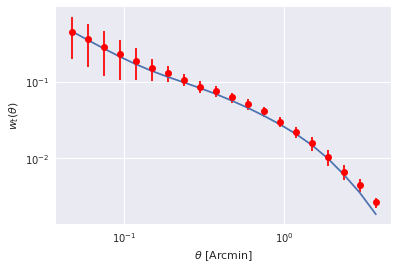

In [69]:
tbins = (theta_bins[1:]+theta_bins[:-1])/2.0
#plt.plot(np.degrees(tpoints),_wt)
#plt.plot(np.degrees(tpoints), wt)
plt.plot(np.degrees(tpoints), wt2)

plt.errorbar(np.degrees(tpoints), wt_redmagic, yerr = np.sqrt(np.diag(cov)), fmt = 'o',
             capsize = 50, label = 'Buzzard Mock', color = 'r')

#plt.plot(tbins, _wt)
plt.ylabel(r'$w_t(\theta)$')
plt.xlabel(r'$\theta$ [Arcmin]')
plt.xticks()
plt.loglog();
#plt.xlim([60, 240])
#plt.ylim([0, 2])
#plt.xscale('log')

In [274]:
gt_data = hdulist[3].data
gt_rm, gt_bc = [],[]
for i, row in enumerate(gt_data):
    if i == 20:
        break
    gt_rm.append(row[3])#gt_data[3,:20]
    gt_bc.append(row[4])


NameError: name 'hdulist' is not defined

In [ ]:
print gt_bc
print tbins*60

In [ ]:
plt.plot(gt_bc, gt_rm)
plt.plot(tbins*60, sigma_crit_inv*gt/cat.h)#/cat.h)
plt.ylabel(r'$\gamma_t(\theta)$')
plt.xlabel(r'$\theta$ [Arcmin]')
plt.loglog()